# 优化的总结

## pytorch SDPA

是一种经过优化且内存高效的注意力机制（类似于 xFormers），可根据模型输入和 GPU 类型自动启用多种其他优化。

如果您使用 PyTorch 2.0 和最新版本的 🤗 Diffusers，则默认启用 SDPA，因此您无需在代码中添加任何内容。

In [1]:
import torch

torch.__version__

'2.1.1+cu121'

## xFormers

推荐xFormers进行推理和训练。在我们的测试中，在注意力块中执行的优化可以提高速度并减少内存消耗。

安装：

```
! pip install xformers
```

通过 `enable_xformers_memory_efficient_attention` 函数使用。

## 使用示例

### 默认情况 - pytorch 优化

即通过 PyTorch 优化。

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 6.016029357910156 秒


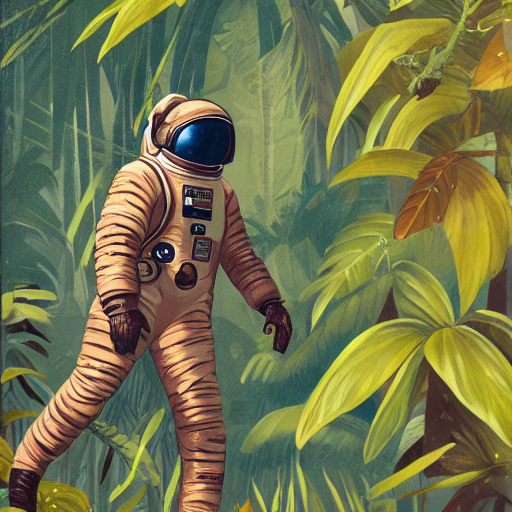

In [1]:
from diffusers import AutoPipelineForText2Image
import torch
import time

start_time = time.time()

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 3.8184351921081543 秒


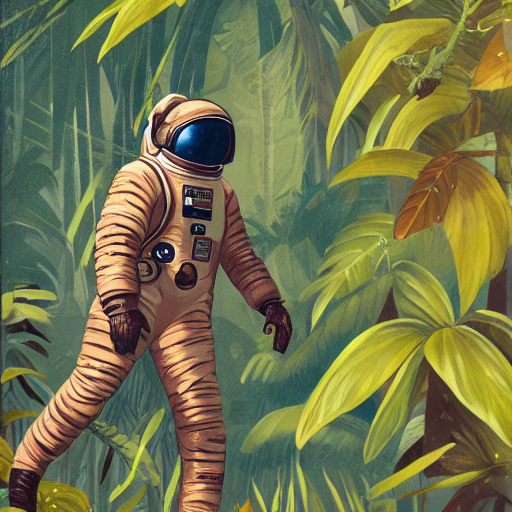

In [2]:
start_time = time.time()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

### xFormers

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 6.308081150054932 秒


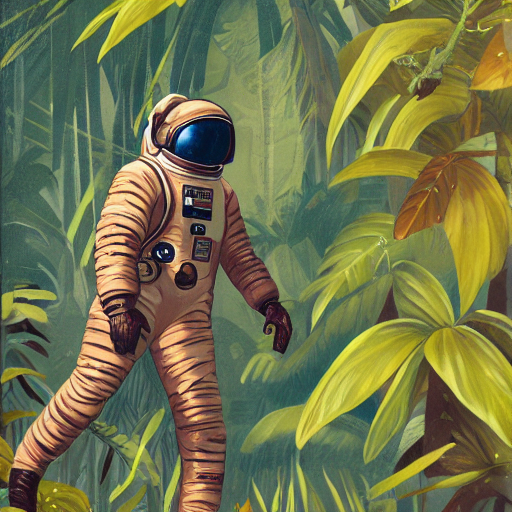

In [1]:
from diffusers import AutoPipelineForText2Image
import torch
import time

start_time = time.time()

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")
pipeline.enable_xformers_memory_efficient_attention()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 3.7878146171569824 秒


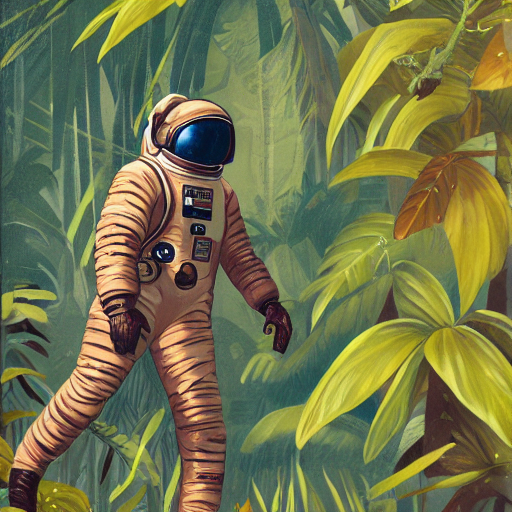

In [2]:
start_time = time.time()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

### enable_model_cpu_offload

使用加速将所有模型卸载到 CPU，减少内存使用，对性能影响很小。 

与enable_sequential_cpu_offload相比，该方法在调用其forward方法时一次将整个模型移动到GPU，并且该模型保留在GPU中直到下一个模型运行。 

内存节省低于使用enable_sequential_cpu_offload，但由于unet的迭代执行，性能要好得多。

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 8.19029951095581 秒


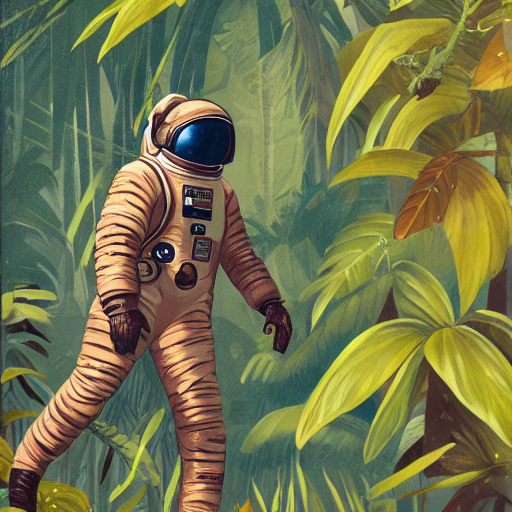

In [1]:
from diffusers import AutoPipelineForText2Image
import torch
import time

start_time = time.time()

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

pipeline.enable_model_cpu_offload() 
# pipeline.enable_xformers_memory_efficient_attention()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 5.093688249588013 秒


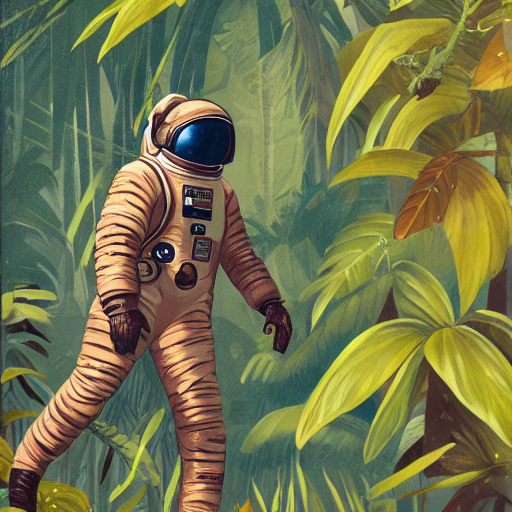

In [2]:
start_time = time.time()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

### reduce-overhead 模式

通过用它包装 UNet 来进一步提高推理速度

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 46.430968284606934 秒


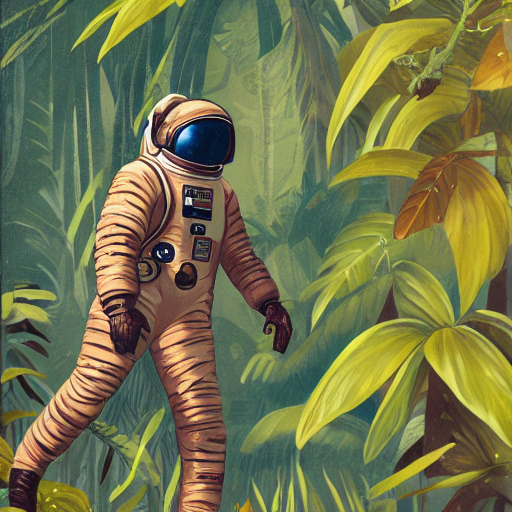

In [1]:
from diffusers import AutoPipelineForText2Image
import torch
import time

start_time = time.time()

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

# pipeline.enable_model_cpu_offload() 
# pipeline.enable_xformers_memory_efficient_attention()
pipeline.unet = torch.compile(pipeline.unet, mode="reduce-overhead", fullgraph=True)

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

  0%|          | 0/50 [00:00<?, ?it/s]

函数调用耗时: 3.600187301635742 秒


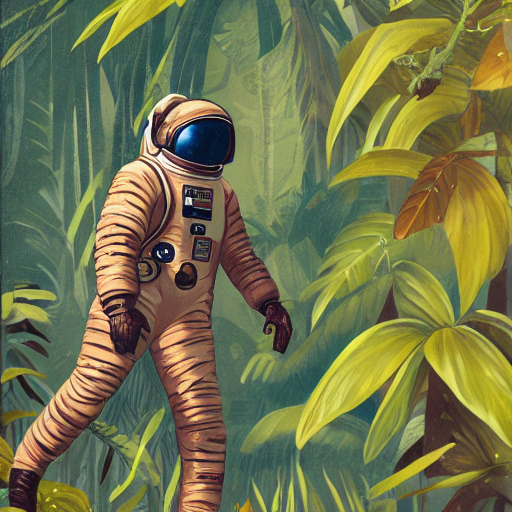

In [2]:
start_time = time.time()

generator = torch.Generator("cuda").manual_seed(31)

image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"函数调用耗时: {elapsed_time} 秒")

image

## 总结

初步结论，使用 xformer+enable cpu offload

| 方式                 | 内存(GB) | 显存(MB) | 耗时1(秒) | 耗时2(秒) |
| ------------------ | ------ | ------ | ------ | ------ |
| 默认-pytorch         | 21     | 3644   | 6.167  | 3.818  |
| XFormer            | 21     | 3656   | 6.092  | 3.788  |
| enable cpu offload | 22     | 3504   | 8.190  | 5.094  |
| reduce overhead    | 22     | 4338   | 46.431 | 3.600  |